# Regressão Logística | S07

# Introdução

Horácio, um cientista de dados da EdPuk, uma EdTech, quer prever a probabilidade de admissão de candidatos em instituições de ensino superior, como a PUC-SP. Para serem admitidos, os candidatos devem prestar e passar no vestibular. A EdPuk desenvolveu uma série de provas e atividades que testa o conhecimento dos candidatos e irá oferecer uma probabilidade de admissão no curso desejado. Os candidatos que fizerem os testes da EdPuk receberão uma pontuação, que varia de $0$ a $1.000$. Ao final, a EdTek irá vender a probabilidade de admissão nos cursos aos candidatos juntamente com um relatório de seus pontos fortes e fracos.

Para treinar um modelo, o cientista de dados recebeu um dataset de $1.000$ candidatos ao vestibular de direito na PUC-SP, contendo a pontuação nas provas EdPuk dos candidatos e seus resultados de admissão (`FOI ADMITIDO` ou `NÃO FOI ADMITIDO`).

A tabela a seguir ilustra o dataset.


pontuação | admitido
--------  | ---------
900       | 1
852       | 1
769       | 0
757       | 1
157       | 0
501       | 0


O próprio Horácio, para entender melhor o processo, realizou as provas EdPuk e recebeu uma pontuação de $762$.

Com estes dados, o cientista de dados gostaria de fazer o seguinte:

* Desenvolver um modelo que irá fornecer a probabilidade e as chances de ser admitido para qualquer pontuação.

* Descobrir aproximadamente qual pontuação está associada com uma probabilidade de $50$% (chances iguais) de ser admitido.

* Descobrir a probabilidade (e chances) de ser admitido num curso de Direito da PUC-SP.

* Descobrir como aumentar a pontuação de $762$ para $800$ afetará as probabilidades e chances de ser aprovado em Direito na PUC-SP.


##### Bibliotecas e frameworks

Bibliotecas de código a serem utilizadas neste caderno.

In [2]:
from math import e, log
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
import numpy as np
from cdia.datasets import DatasetCandidatos as DC
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LogisticRegression
import numpy as np

#### Dataset

In [47]:
n_estudantes = 1000
df = DC.criar(n_estudantes)
df.head()

,pontuação,admitido
0,79,0
1,172,0
2,198,0
3,197,0
4,11,0


In [64]:
df.groupby('admitido')

In [48]:
# Verifica a correlação entre as variáveis
df.corr()

,pontuação,admitido
pontuação,1.000000,0.851161
admitido,0.851161,1.000000


#### Visualizando os dados

In [49]:
def plotar(x, y):
    fig = px.scatter(
        x=x, 
        y=y, 
        opacity=0.8, 
    )
    fig.update_traces(marker=dict(size=12))
    fig.show()

In [50]:
plotar(df.pontuação, df.admitido)

## Regressão Linear

A Regressão Linear não seria apropriada para resolver o problema.

a) O que aconteceria com os valores da variável dependente $Y$? Que intervalo $Y$ poderia assumir? E quais valores deveriam assumir?

*Escreva sua resposta aqui*

b) O que o coeficiente de regressão significaria neste caso?

*Escreva sua resposta aqui*

c) E o intercepto? O que significaria?

*Escreva sua resposta aqui*

<img src="img/linear_vs_logistic_regression.webp">

# Regressão Logística

A Regressão Linear não é adequada para os casos em que a variável dependente é categórica. A variável dependente ($Y$) também pode ser chamada de variável **dicotômica**, **binária** ou **categórica**.

A Regressão Logística resolve esse problema ao ajustar uma curva em formato de S nos dados.

A meta da Regressão Logística é estimar uma probabilidade $p$ para uma combinação linear de variáveis independentes. A estimativa de $p$ é representada como $\hat{p}$.

## A função logística (*logit*)

A função logística é um tipo de sigmóide (a curva em S) e pode ser definida como a seguir.

$$
f(p) = ln(chances)
$$

$$
f(p) = ln(\frac{p}{1-p})
$$

A implementação da função logística $f(x)$ em Python.

In [8]:
def logit(p):
    return log(p / (1 - p))

In [9]:
def c(p):
    return p / (1 - p)

**Características do $logit$**

- Não tem limites. Varia de $-\infty$ (impossibilidade negativa) a $+\infty$ (certeza virtual)

- Valores negativos de $L$ representam chances menores que iguais

- $L = 0$ representa chances iguais de ocorrência

- Valores positivos de $L$ representam chances maiores que iguais

**Estudo do comportamento da função logística**

Mude os argumentos na função abaixo e observe os resultados.

In [22]:
logit(0.999999)

13.815509557935018

* Que valores podemos colocar como argumento para a função $f(p)$?

In [23]:
def gerar_pontos(min_, max_, fn, incremento=0.01):
    # Define os limites mínino e máximo da sigmóide
    p = min_
    x, y = [], []
    while p < max_:
        # Gera os pontos da variável independente (eixo x)
        x.append(p)

        # Gera os pontos da variável independente (eixo y)
        y.append(fn(p))

        # Muda a probabilidade
        p += incremento
    return x, y

In [29]:
x, y = gerar_pontos(min_=0.01, max_=0.99, fn=logit)
# Plota os conjuntos de pontos no gráfico
plotar(x, y)

A função $f(p)$ não retorna uma probabilidade, mas usa a probabilidade como argumento.

### O *logit* inverso

A função $logit(p)$ retorna o *logit* da função.

$$
logit(p) = ln(\frac{p}{1-p})
$$

A função $g(x)$ retorna o inverso do *logit* da função.

$$
g(x)^{-1} = \frac{e^{x}}{1 + e^{x}}
$$

In [89]:
def g(x):
    return (e ** x) / (1 + e ** x)

**Estudo do comportamento do *logit* inverso**

In [91]:
g(0)

0.5

* Que valores podemos colocar como argumento para a função $g(x)$?

In [27]:
x, y = gerar_pontos(min_=-5, max_=5, fn=g)
plotar(x, y)

## Estimativa da equação de regressão

### Modelagem matemática

O logaritmo natural da razão das chances é equivalente a uma função linear das variáveis independentes. O antilog da função *logit* $f(p)$ permite obter a equação de regressão.

$$
logit(p)
$$

É igual a:

$$
ln(\frac{p}{1 - p}) = \beta_{0} + \beta_{1}x
$$

Aplicando-se o antilog:

$$
\frac{p}{1 - p} = e^{\beta_{0} + \beta_{1}x}
$$

Multiplicando os dois lados por $(1 - p)$:

$$
p = e^{\beta_{0} + \beta_{1}x}(1 - p)
$$

Aplicando-se a regra da distribuição:

$$
p = e^{\beta_{0} + \beta_{1}x} - e^{\beta_{0} + \beta_{1}x} * p
$$

Somando os dois lados por $e^{\beta_{0} + \beta_{1}x} * p$:

$$
p + e^{\beta_{0} + \beta_{1}x} * p = e^{\beta_{0} + \beta_{1}x}
$$

Isolando $p$:

$$
p * (1 + e^{\beta_{0} + \beta_{1}x}) =  e^{\beta_{0} + \beta_{1}x}
$$

Dividindo-se ambos os lados por $(1 + e^{\beta_{0} + \beta_{1}x})$:

$$
p =  \frac{e^{\beta_{0} + \beta_{1}x}}{1 + e^{\beta_{0} + \beta_{1}x}}
$$

$$
p =  \frac{1}{1 + e^{-(\beta_{0} + \beta_{1}x)}}
$$

### Estimativa por Máxima Verossimilhança

Para encontrar os coeficientes da equação de regressão podemos utilizar o método da máxima verossimilhança. Os detalhes matemáticos do método ultrapassam os níveis de complexidade do nível desta matéria. Mas podemos ter uma ideia de como o método funciona assistindo alguns vídeos. Sugiro o vídeo do Josh Starmer, criador do canal StatQuest. Apesar do vídeo estar em inglês, a tradução automática está muito boa.

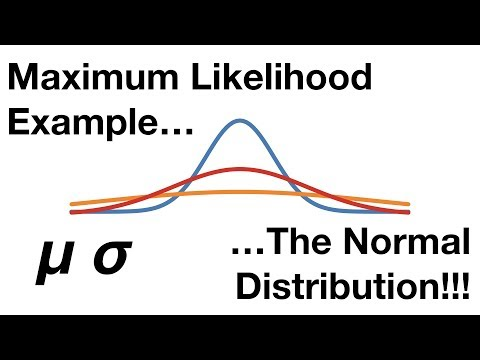

In [30]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('Dn6b9fCIUpM')

Como alternativa, vamos calcular os coeficientes utilizando o `sklearn`.

In [51]:
X = [[x] for x in df.pontuação]
y = [y for y in df.admitido]

In [80]:
lr = LogisticRegression(random_state=0, solver='sag', max_iter=10 ** 4)
clf = lr.fit(X, y)
beta0 = clf.intercept_[0]
beta1 = clf.coef_[0][0]
print(f"beta0: {beta0}\tbeta1: {beta1}")

beta0: -1.7413096333248066	beta1: 0.005393019019444177


Com os coeficientes da equação de regressão, podemos criar a função hipótese $h(x)$, capaz de retornar uma probabilidade de admissão.

In [78]:
def h(x):
    beta0 = -1.7413096333248066
    beta1 = 0.005393019019444177
    return e ** (beta0 + beta1 * x) / (1 + e ** (beta0 + beta1 * x))

In [92]:
h(762)

0.9143677485274001

Vamos plotar todas as probabilidades de para notas de $0$ a $1000$.

In [93]:
x, y = gerar_pontos(min_=0, max_=1000, fn=h, incremento=1)
plotar(x, y)

Para efeito de comparação, vamos calcular a mesma probabilidade com o `sklearn`.

In [95]:
#clf.predict_proba([[762]])
clf.predict([[762]])

array([1])

## Estimativa dos coeficientes por gradiente descendente

Os códigos a seguir ilustram o funcionamento da função logística para obter a probabilidade de admissão.

### Função hipótese (sigmóide)

$$
z = \beta_{0}1 + \beta_{1}X_{1} + \beta_{2}X_{2} + ... + \beta_{n}X_{n}
$$

$$
sigmoide(z) = \frac{1}{1 + e^{-z}}
$$


In [98]:
def sigmoide(x, betas, beta0):
    z = np.dot(betas.T, x) + beta0
    return 1 / (1 + np.exp(-z))

### Função de custo logística

$$
J(\theta) = \frac{1}{m}\sum_{i=1}^{m}y_{i}log(h_{\theta}(x_{i}))~+~(1-y_{i})log(1-h_{\theta}(x_{i}))
$$

In [96]:
def grad_desc(X, y, alpha, n_épocas):
    betas = np.zeros_like(X[0])
    beta0 = 1
    
    # Quantidade de instâncias
    m = len(X)
    for época in range(n_épocas):
        
        for i in range(m):
            # Faz a predição
            y_pred = sigmoide(X[i], betas, beta0)
            
            J = -1/m * sum((y * np.log(y_pred)) + (1- y) * np.log(1-y_pred))
            
            # Calcula os gradientes
            grad_bs = X[i] * (y_pred - y[i])
            grad_b0 = y_pred - y[i]
            
            # Atualiza os coeficientes  
            betas = betas - alpha * grad_bs / m
            beta0 = beta0 - alpha * grad_b0 / m

        if (época % 500 == 0):
            print(f"beta0: {beta0}\tbeta1: {betas[0]}")
            #print(f">> custo: {J}")
    betas.insert(0, beta0)
    return betas

In [ ]:
#grad_desc(np.array(X), np.array(y), 0.009, 4 * 10 ** 4)
grad_desc(np.array(X), np.array(y), 0.9, 10 ** 4)

Valores dos coeficientes do `sklearn`:
```
beta0: -1.7413096333248066	
beta1: 0.005393019019444177
```

# Referências

Levin, J., Fox, J. A., Forde, D. R. **Elementary Statistics in Social Research**. Pearson. New York, 2003

Provost, F., Fawcett, T. **Data Science for Business: What you need to know about Data Mining and Data-Analytic Thinking**. O'Reilly. Sebastopol, 2013.

Albon, C. **Machine Learning Cookbook: Practical Solutions From Preprocessing to Deep Learning**. O'Reilly. Sebastopol, 2018.